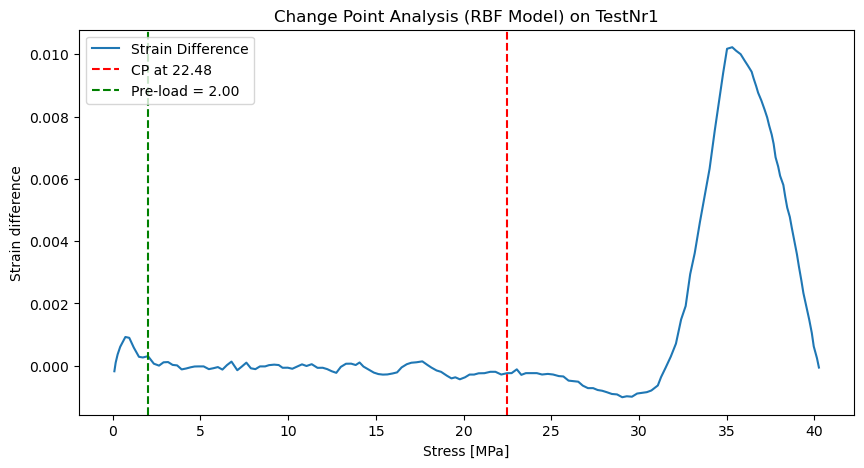

RBF model on given data:
 Pre-load = 2.0 MPa
 Changepoint at x = 22.48 MPa
 Penalty needed to get a singular changepoint: pen = 31


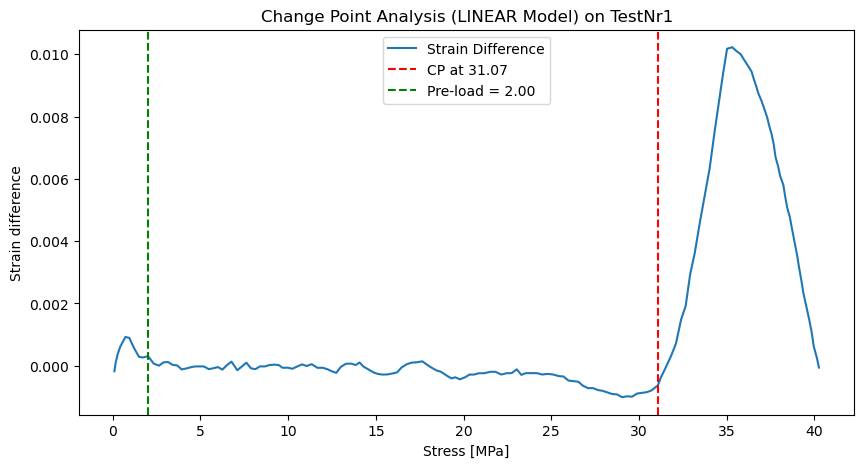

LINEAR model on given data:
 Pre-load = 2.0 MPa
 Changepoint at x = 31.07 MPa
 Penalty needed to get a singular changepoint: pen = 5021


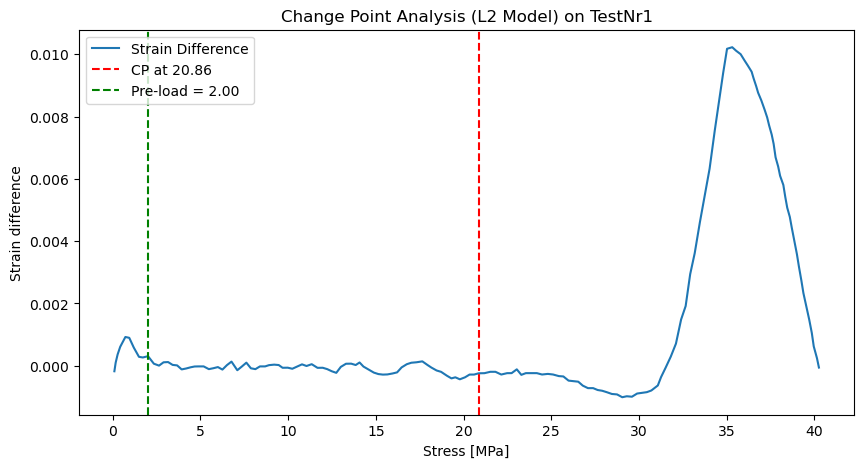

L2 model on given data:
 Pre-load = 2.0 MPa
 Changepoint at x = 20.86 MPa
 Penalty needed to get a singular changepoint: pen = 3391
Stored CPA for TestNr1 in cpaResultsFilename.csv


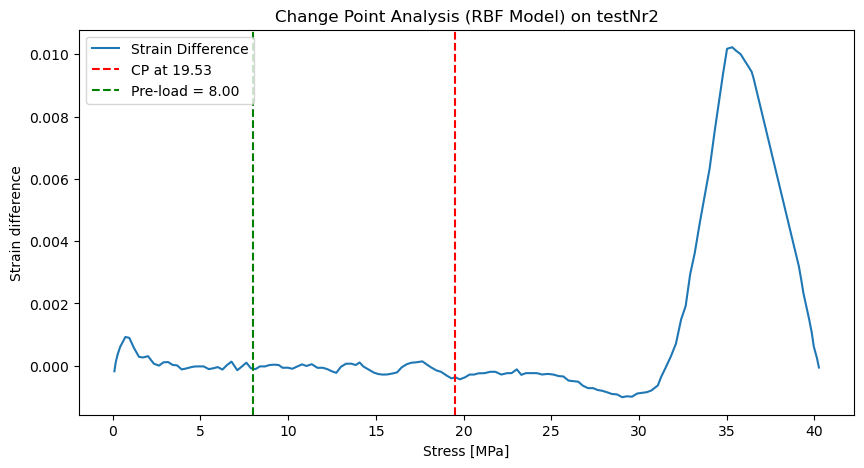

RBF model on given data:
 Pre-load = 8.0 MPa
 Changepoint at x = 19.53 MPa
 Penalty needed to get a singular changepoint: pen = 21


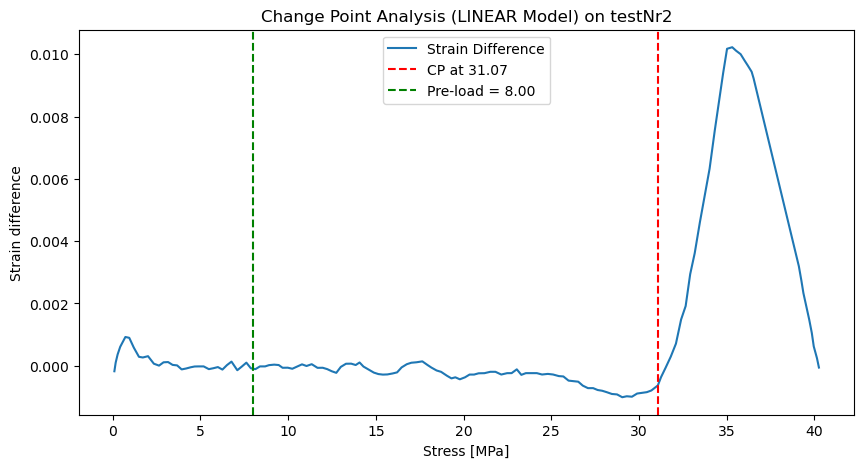

LINEAR model on given data:
 Pre-load = 8.0 MPa
 Changepoint at x = 31.07 MPa
 Penalty needed to get a singular changepoint: pen = 4941


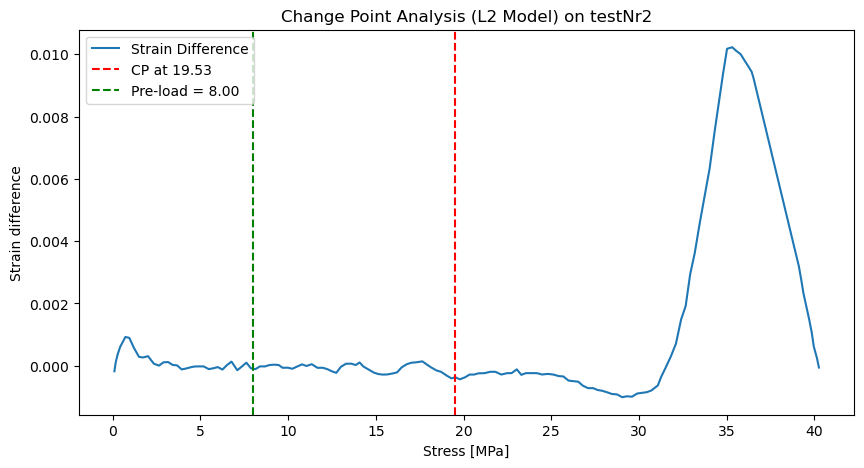

L2 model on given data:
 Pre-load = 8.0 MPa
 Changepoint at x = 19.53 MPa
 Penalty needed to get a singular changepoint: pen = 2831
Stored CPA for testNr2 in cpaResultsFilename.csv


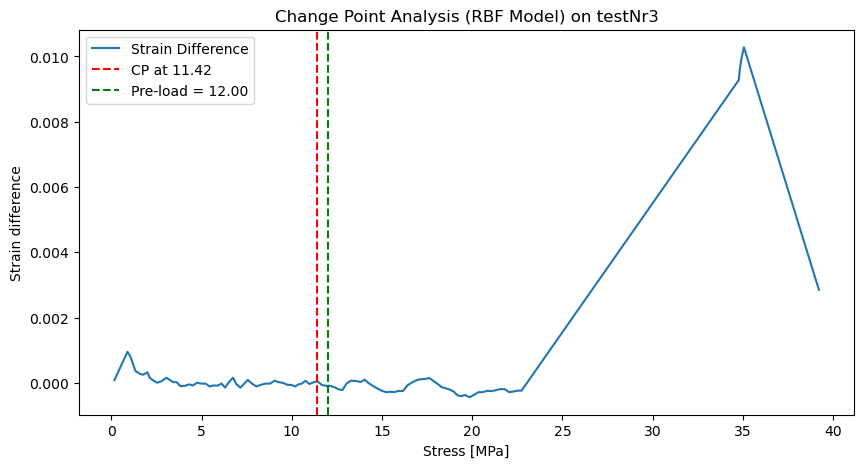

RBF model on given data:
 Pre-load = 12.0 MPa
 Changepoint at x = 11.42 MPa
 Penalty needed to get a singular changepoint: pen = 21


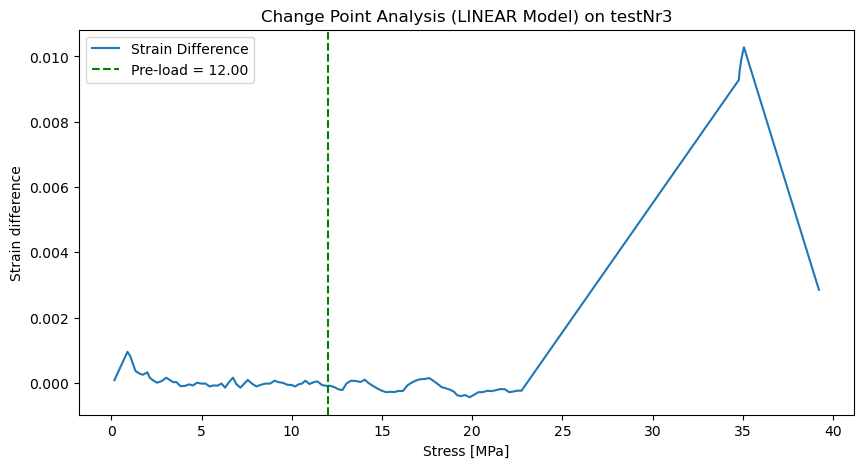

LINEAR model on given data:
 Pre-load = 12.0 MPa
Changepoint not found


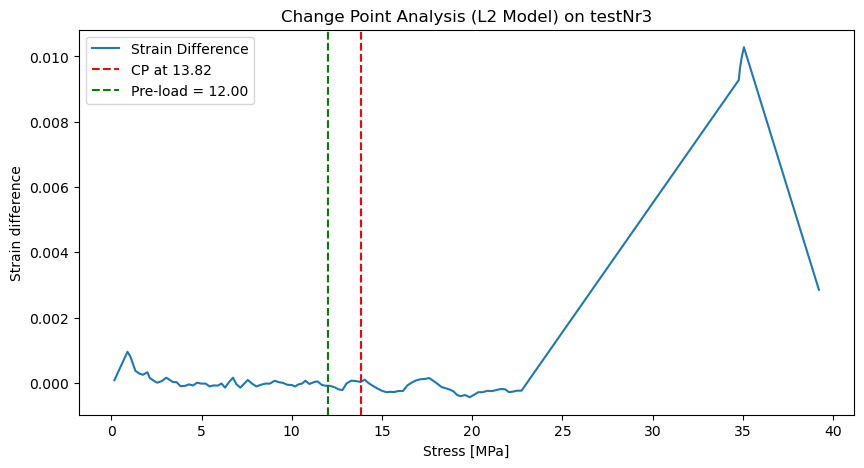

L2 model on given data:
 Pre-load = 12.0 MPa
 Changepoint at x = 13.82 MPa
 Penalty needed to get a singular changepoint: pen = 1191
Stored CPA for testNr3 in cpaResultsFilename.csv


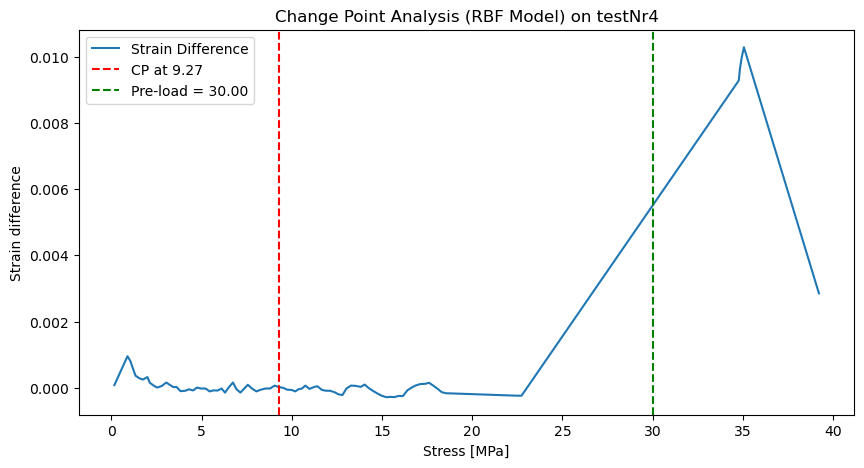

RBF model on given data:
 Pre-load = 30.0 MPa
 Changepoint at x = 9.27 MPa
 Penalty needed to get a singular changepoint: pen = 11


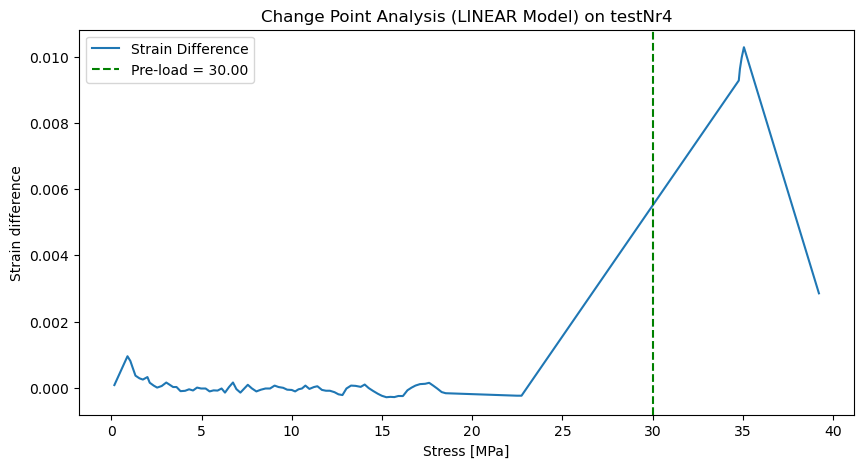

LINEAR model on given data:
 Pre-load = 30.0 MPa
Changepoint not found


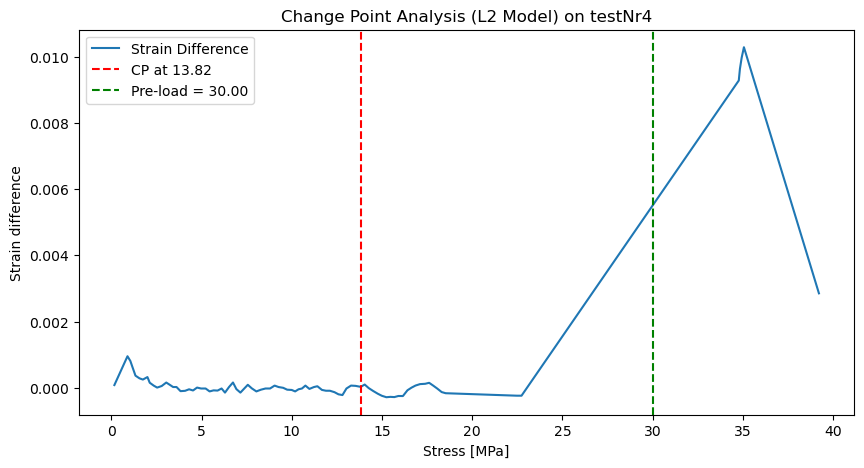

L2 model on given data:
 Pre-load = 30.0 MPa
 Changepoint at x = 13.82 MPa
 Penalty needed to get a singular changepoint: pen = 1551
Stored CPA for testNr4 in cpaResultsFilename.csv


In [2]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ruptures as rpt
from scipy.interpolate import interp1d

# ----------------------------
# User-defined Configuration
# ----------------------------
# Input the filename for the CSV file containing raw data in the required format
rawFilename = "rawDataExampleFilename"    # Do not include ".csv"

# Input the filename for the CSV file where CPA results are to be stored
cpaFilename = "cpaResultsExampleFilename"  # Do not include ".csv"



# ----------------------------
# CPA Storage Function
# ----------------------------
# Function extracts, divides, and calculates strain difference from raw data
def process_experiments(raw_filename, cpa_filename):
    """
    Reads raw_filename.csv, splits into 6-col experiments, computes y_diff,
    and runs CPA for each, storing to cpa_filename.csv.
    
    Parameters:
    - raw_filename: Name of the CSV file containing raw data
    - cpa_filename: Name of the CSV file the CPA results are to be stored
    """
    delim = detect_delimiter(f"{raw_filename}.csv")
    df = pd.read_csv(f"{raw_filename}.csv", sep=delim)
    cols = df.columns.tolist()
    if len(cols) % 6 != 0:
        raise ValueError("Raw data must have columns in multiples of 6.")

    for i in range(len(cols)//6):
        base = i*6
        dataTag = cols[base]
        try:
            preLoad = float(cols[base+1])
        except ValueError:
            preLoad = cols[base+1]

        x0 = df[cols[base+2]].dropna().values
        y0 = df[cols[base+3]].dropna().values
        x1 = df[cols[base+4]].dropna().values
        y1 = df[cols[base+5]].dropna().values

        # compute y_diff via interpolation
        if len(x0) >= len(x1):
            base_x, base_y1 = x1, y1
            f = interp1d(x0, y0, bounds_error=False, fill_value='extrapolate')
            y0i = f(base_x)
            y_diff = base_y1 - y0i
        else:
            base_x, base_y0 = x0, y0
            f = interp1d(x1, y1, bounds_error=False, fill_value='extrapolate')
            y1i = f(base_x)
            y_diff = y1i - base_y0

        # run CPA
        change_point_analysis(dataTag, base_x, y_diff, preLoad, cpa_filename)
    return

# Function performs changepoint analysis
def change_point_analysis(dataTag, x_stress, y_straindiff, preLoad,
                          filename):
    """
    Performs change point analysis on the input data using three different models ("rbf", "linear", "l2"),
    plots the results.
    
    Parameters:
    - dataTag: Unique identifier for the DRA experiment
    - x_stress: List or array of x-axis values representing stress.
    - y_straindiff: List or array of y-axis values representing strain difference.
    - preLoad: Pre-load value associated with the data.
    - filename: Parameters: Name of the CSV file the CPA results are to be stored
    """
    model_types = ["rbf", "linear", "l2"]
    cp_results = {}
    data_set = np.column_stack((x_stress, y_straindiff))
    for model in model_types:
        sens = 1
        algo = rpt.Pelt(model=model).fit(data_set)
        result = algo.predict(pen=sens)

        # if more than 2 boundaries (CP + end), raise penalty until only 2 remain
        while len(result) > 2:
            sens += 10
            result = algo.predict(pen=sens)
        
        # no change-point found at all
        if len(result) == 0:
            cp_idx = None
        # only one boundary; could be a “real” CP or just the end-of-signal
        elif len(result) == 1:
            idx = result[0]
            cp_idx = idx if idx < len(x_stress) else None
        # len(result) == 2; we expect [cp_index, len(x_stress)]
        else:
            cp, boundary = result
            cp_idx = cp if cp < len(x_stress) else None


        # Plot the strain difference curve and the detected change point(s)
        plt.figure(figsize=(10, 5))
        plt.plot(x_stress, y_straindiff, label="Strain Difference")
        if cp_idx is not None:
            plt.axvline(x=x_stress[cp_idx], linestyle='--', color='red',
                        label=f"CP at {x_stress[cp_idx]:.2f}")
        plt.axvline(x=preLoad, linestyle='--', color='green',
                label=f"Pre-load = {preLoad:.2f}")
        plt.title(f"Change Point Analysis ({model.upper()} Model) on {dataTag}")
        plt.xlabel("Stress [MPa]")
        plt.ylabel(f"Strain difference")
        plt.legend()
        plt.show()
        
        # Displaying complimentary information
        if cp_idx is not None:
            print(f"{model.upper()} model on given data:")
            print(f' Pre-load = {preLoad} MPa')
            print(f' Changepoint at x = {round(x_stress[cp_idx], 2)} MPa')
            print(f' Penalty needed to get a singular changepoint: pen = {sens}')
        else:
            print(f"{model.upper()} model on given data:")
            print(f' Pre-load = {preLoad} MPa')
            print(f"Changepoint not found")
            
            
            
        
        cp_results[model] = x_stress[cp_idx] if cp_idx is not None else None

    # store results
    store_cpa_results_csv(dataTag, preLoad, cp_results, filename)
    return

# Function stores the CPA results in a CSV file
def store_cpa_results_csv(dataTag, preLoad, cp_results, filename):
    """
    Appends CPA results to filename.csv under header:
    dataTag,preLoad,rbfCP,linearCP,l2CP
    
    Parameters:
    - dataTag: Unique identifier for the DRA experiment
    - preLoad: Pre-load value associated with the data.
    - cp_results: Array containing the CPA results
    - filename: Name of the CSV file the CPA results are to be stored
    """
    filepath = f"{filename}.csv"
    # create file and header if missing
    if not os.path.exists(filepath):
        with open(filepath, 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["dataTag", "preLoad", "rbfCP", "linearCP", "l2CP"])

    new_row = [dataTag, preLoad,
               cp_results.get('rbf'),
               cp_results.get('linear'),
               cp_results.get('l2')]

    if check_unique(filename, new_row):
        print(f"{dataTag} already in {filename}.csv. Skipping.")
    else:
        with open(filepath, 'a', newline='', encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(new_row)
        print(f"Stored CPA for {dataTag} in {filename}.csv")
    return

# Function which detects what delimiter is used in a CSV file
def detect_delimiter(filename):
    """
    Heuristic delimiter detection: counts commas, semicolons, tabs in the first 2KB
    and returns the character with the highest count (comma wins ties).
    
    Parameter:
    - filename: Name of the CSV file which is to be checked
    """
    with open(filename, 'r', newline='') as f:
        sample = f.read(2048)
    counts = {',': sample.count(','), ';': sample.count(';'), '\t': sample.count('\t')}
    return max(counts, key=lambda k: (counts[k], k == ','))

# Function which checks if an experiment has already been stored in the CSV file we are storing the processed data to.
def check_unique(filename, new_row):
    """
    Checks if a row with the same dataTag (first element of new_row) exists in filename.csv.
    
    Parameter:
    - filename: Name of the CSV file which is to be checked for existing dataTags.
    - new_row: The row in the CSV file containing the unique identifier "dataTag"
    """
    filepath = f"{filename}.csv"
    key = new_row[0]
    if not os.path.exists(filepath):
        return False
    with open(filepath, 'r', newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        next(reader, None)  # skip header
        for row in reader:
            if row and row[0] == key:
                return True
    return False

# Running the algorithm
process_experiments(rawFilename, cpaFilename)
